In [1]:
import numpy as np
from pyts.bag_of_words import BagOfWords
from typing import Callable
import tensorflow as tf
from timeit import default_timer as timer
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

2023-10-31 20:33:09.022266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read data

In [2]:
user1_file = "./synchrony_score/sync_score_data/1_P1_3MIN.csv"
user2_file = "./synchrony_score/sync_score_data/1_P2_3MIN.csv"

In [3]:
def load_data(file):
    df = pd.read_csv(file)

    smile = []
    for au06_c, au12_r in zip(df[" AU06_c"], df[" AU12_r"]):
        smile.append((au12_r if (au06_c == 1) else 0))

    return [smile]

# of data in user1: 1
	Length of smile data: 5400
# of data in user2: 1
	Length of smile data: 5400


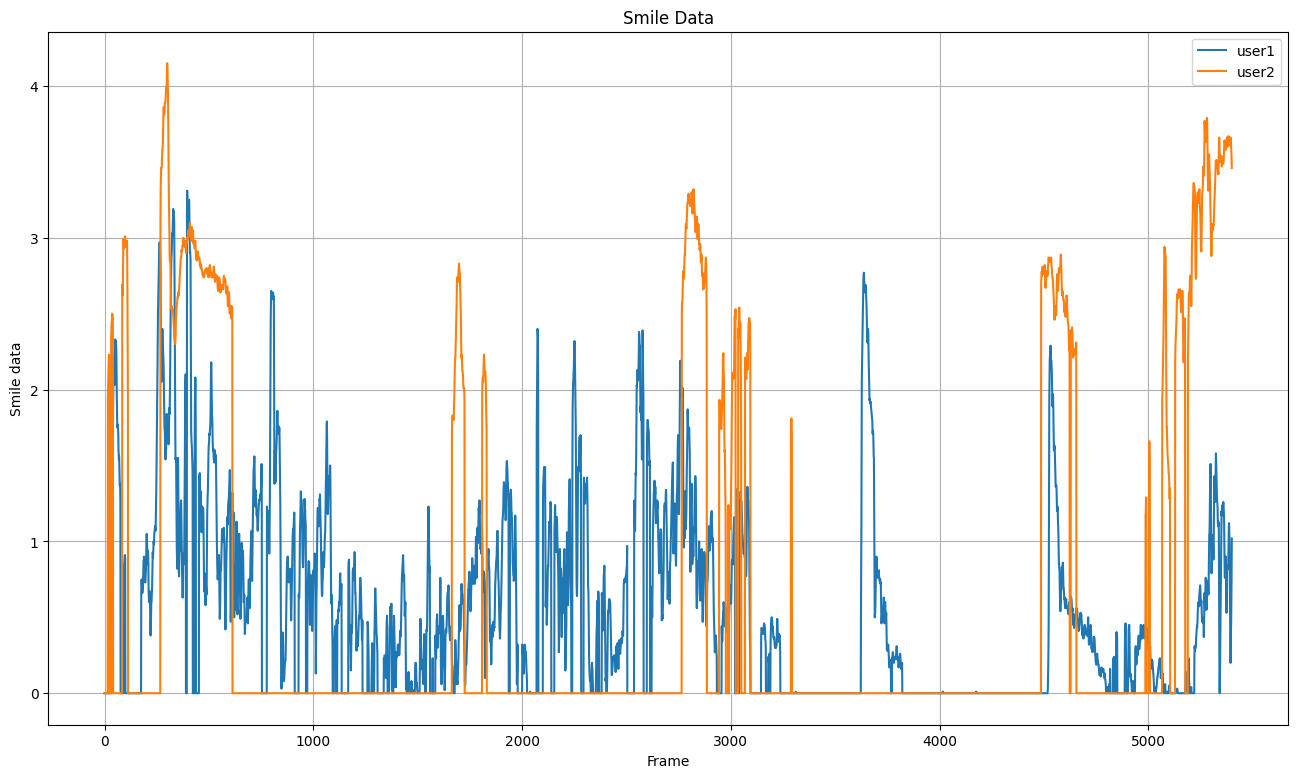

In [4]:
user1 = load_data(user1_file)
user2 = load_data(user2_file)


for k, v in {"user1": user1, "user2": user2}.items():
    print(f"# of data in {k}: {len(v)}")

    for l in v:
        print(f"\tLength of smile data: {len(l)}")


for u1, u2 in zip(user1, user2):
    fg = plt.figure(figsize=(16, 9))

    plt.plot(u1, label = "user1")
    plt.plot(u2, label = "user2")

    plt.title("Smile Data")

    plt.xlabel("Frame")
    plt.ylabel("Smile data")
    plt.grid()

    plt.legend(loc = "upper right")

# Original Implementation ([Synchrony Score Repo](https://github.com/MaxHenneberg/synchrony_score))

In [5]:
def derivative(excel):
    dx = 0.1
    derivedSheets = list()
    for sheet in excel:
        derivedSheets.append(np.gradient(sheet, dx))
    return derivedSheets

def normalizeData(data):
    min_val = tf.reduce_min(data)
    max_val = tf.reduce_max(data)
    if min_val == max_val:
        if min_val > 0:
            return data // min_val
        else:
            return data

    data_norm = (data - min_val) / (max_val - min_val)

    return data_norm

def splitWordsIntoBuckets(bowList, nBuckets: int):
    buckets = [[] for i in range(nBuckets)]
    for i, word in enumerate(bowList):
        bin = buckets.pop(i % nBuckets)
        bin.append(word)
        buckets.insert(i % nBuckets, bin)

    return buckets

def bowForTwoUsers(bow: BagOfWords, userData1, userData2):
    summedWordBucketsUser1 = list()
    summedWordBucketsUser2 = list()
    nBuckets = bow.window_size // bow.window_step
    for i, (u1, u2) in enumerate(zip(userData1, userData2)):
        bowDyad = BagOfWords(window_size=bow.window_size, word_size=bow.word_size,
                 window_step=bow.window_step, numerosity_reduction=False, n_bins=bow.n_bins, strategy=bow.strategy)
        start = timer()
        mergedSheets = list(np.append(u1, u2))
        startBow = timer()
        mergedBows = bowDyad.transform([mergedSheets])
        endBow = timer()
        print(f'Only Bow took {endBow - startBow} for {i}')


        overlap = (bow.window_size-bow.window_step)
        seperationIdx = (len(u1)//bow.window_step)
        listOfWords = mergedBows[0].split(' ')
        user1Words = listOfWords[0:seperationIdx-overlap]
        user2Words = listOfWords[seperationIdx:]
        user1Buckets = splitWordsIntoBuckets(user1Words, nBuckets)
        user2Buckets = splitWordsIntoBuckets(user2Words, nBuckets)
        summedWordBucketsUser1.append(user1Buckets)
        summedWordBucketsUser2.append(user2Buckets)
        end = timer()
        print(f'Bow took {end-start} for {i}')

    return (summedWordBucketsUser1, summedWordBucketsUser2)

In [6]:
def calcOriginWordEnergy(pos, wordSize, user1):
    # return np.sum(user1[pos:pos+wordSize]) / wordSize
    sum = 0
    for i in range(wordSize):
        if pos + i < len(user1):
            sum += abs(user1[pos + i])

    # Only interested in Values for User1 (We try to find the Word of User1 in a certain offset in User 2
    # So if User1 Word does not contain a lot of 0 Values, User2 doesnt aswell
    return sum / (wordSize)

def calcEuclideanWordDistance(word, compareWord, alphabetSize):
    distanceSum = 0
    for c1, c2 in zip(word, compareWord):
        # Normalize Distance per Character
        charDistance = (abs(ord(c1) - ord(c2))) / (alphabetSize - 1)
        distanceSum = distanceSum + charDistance
    # Normalize distance per Word
    return distanceSum / len(word)

def calcEuclScynScore(wordBinsUser1, user1, wordBinsUser2, user2, windowSize, alphabetSize):
    syncScore = list()
    for (binsUser1, sheetUser1), (binsUser2, sheetUser2) in zip(zip(wordBinsUser1, user1), zip(wordBinsUser2, user2)):
        start = timer()
        originalBin = binsUser1[0]
        # maxSyncScore = (len(binsUser1) + 1) * (len(binsUser1) / 2)
        syncScoreListForSheet = list()
        for j, word in enumerate(originalBin):
            syncScoreForWord = 0
            energyU1 = calcOriginWordEnergy(j * windowSize, windowSize, sheetUser1)
            energyU2 = calcOriginWordEnergy(j * windowSize, windowSize, sheetUser2)
            minEnergy = min(energyU1, energyU2)
            # closeness = 1 - (abs((energyU1 - energyU2)))
            amtOffsetWords = len(binsUser2)
            if minEnergy > 0.1:
                for x, compareBin in enumerate(binsUser2):
                    if j < len(compareBin):
                        abortCondition = (amtOffsetWords - x) / amtOffsetWords
                        if syncScoreForWord >= abortCondition:
                            break
                        compareWord = compareBin[j]
                        energyU2 = calcOriginWordEnergy((j * windowSize) + x, windowSize, sheetUser2)
                        closeness = 1 - (abs((energyU1 - energyU2)) / windowSize)
                        euclWordFactor = 1 - calcEuclideanWordDistance(word, compareWord, alphabetSize)
                        syncScoreForWord = max(syncScoreForWord,
                                               (abortCondition * euclWordFactor * closeness))
            # Normalize Sync Score
            # syncScoreForWord = syncScoreForWord / maxSyncScore
            # Add SyncScore for Current Word to List
            for x in range(windowSize):
                syncScoreListForSheet.append(syncScoreForWord)

        syncScore.append(syncScoreListForSheet)
        end = timer()
        print(f'Gaussian one direction took {end - start}')
    return syncScore

In [7]:
def calculateSyncScoreForTimeSeries(user1, user2, bow: BagOfWords, user1PreProcessing: Callable,
                                    user2PreProcessing: Callable):
    # Normalize Time Series
    user1 = [normalizeData(sheet) for sheet in user1]
    user2 = [normalizeData(sheet) for sheet in user2]

    # Apply Custom Preprocessing to normalized UserData
    user1 = user1PreProcessing(user1)
    user2 = user2PreProcessing(user2)
    start = timer()
    summedWordBinsUser1, summedWordBinsUser2 = bowForTwoUsers(bow, user1, user2)

    # Calculate SyncScore for both directions U1->U2 and U2->U1
    syncScoreU1U2 = calcEuclScynScore(summedWordBinsUser1, user1, summedWordBinsUser2, user2, bow.window_size,
                                      bow.n_bins)
    syncScoreU2U1 = calcEuclScynScore(summedWordBinsUser2, user2, summedWordBinsUser1, user1, bow.window_size,
                                      bow.n_bins)

    # Average both SyncScore Directions
    startMerge = timer()
    syncScore = list()
    for s1, s2 in zip(syncScoreU1U2, syncScoreU2U1):
        syncScore.append((np.array(s1) + np.array(s2)) / 2)
    end = timer()
    print(f'Merge Took {end - startMerge} time')
    print(f'Took {end - start} time')

    return summedWordBinsUser1, summedWordBinsUser2, syncScore


### Run original implementation

Only Bow took 2.688744727987796 for 0
Bow took 2.6920508719049394 for 0
Gaussian one direction took 6.097663645166904
Gaussian one direction took 8.708371435990557
Merge Took 0.006117336917668581 time
Took 17.504775009816512 time
# of peaks: 44


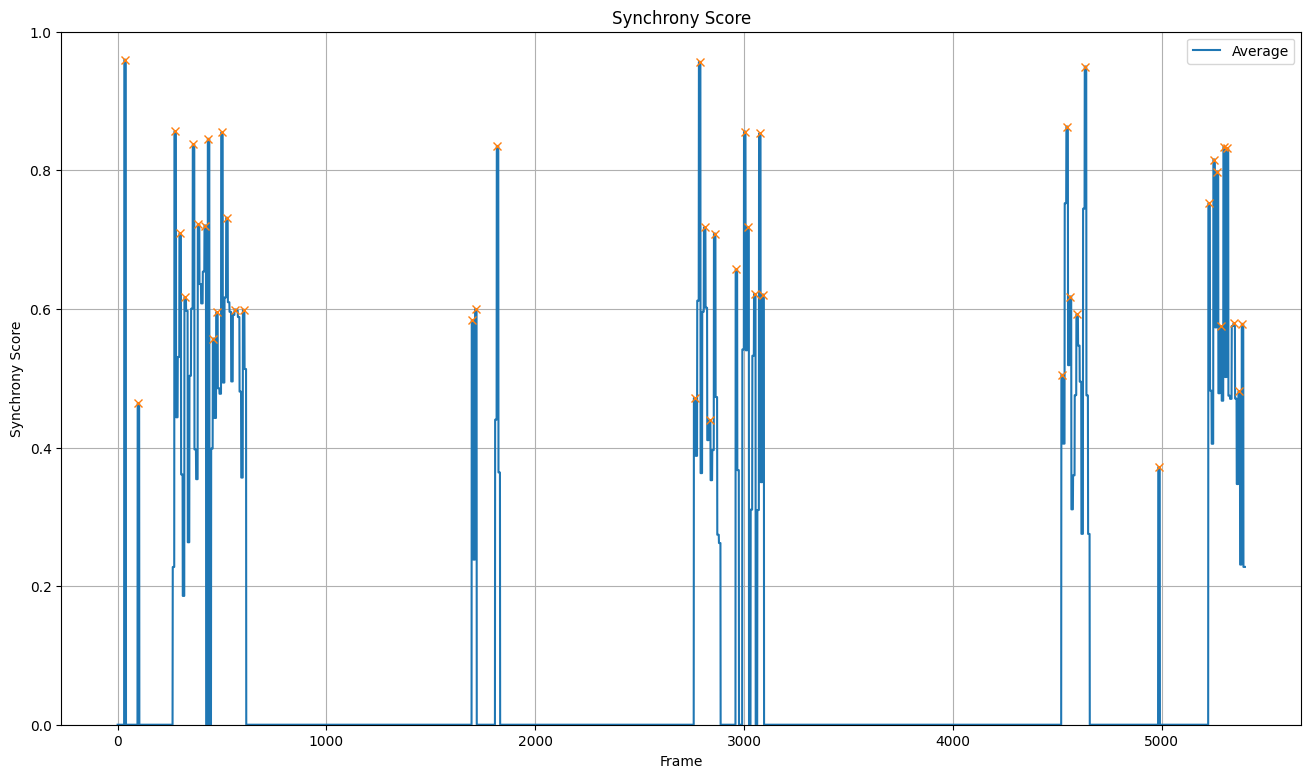

In [8]:
windowSize = 8
wordSize = 4
nBins = 3
windowStep = 1
bow = BagOfWords(window_size=windowSize, word_size=wordSize,
                 window_step=windowStep, numerosity_reduction=False, n_bins=nBins, strategy='uniform')

summedWordBinsUser1, summedWordBinsUser2, syncScoreAvg = calculateSyncScoreForTimeSeries(
    user1,
    user2, 
    bow, 
    lambda data: data, 
    lambda data: data
)


for avg in syncScoreAvg:
    peaks, _ = find_peaks(avg)
    print(f"# of peaks: {len(peaks)}")

    fg = plt.figure(figsize=(16, 9))

    plt.plot(avg, label = "Average")

    plt.plot(peaks, avg[peaks], "x")

    plt.ylim((0, 1))

    plt.title("Synchrony Score")

    plt.xlabel("Frame")
    plt.ylabel("Synchrony Score")
    plt.grid()

    plt.legend(loc = "upper right")

# Group Filter Implementation

In [9]:
def normalize_data(data: np.ndarray) -> np.ndarray:
    min_val = np.min(data)
    max_val = np.max(data)
    if min_val == max_val:
        if min_val > 0:
            return data // min_val
        else:
            return data

    data_normalized = (data - min_val) / (max_val - min_val)

    return data_normalized

class BoW:
    _bow: BagOfWords

    def __init__(self, window_size: int, word_size: int, n_bins: int, strategy: str = "uniform"):
        self._bow = BagOfWords(
            window_size=window_size,
            word_size=word_size,
            n_bins=n_bins,
            window_step=1,
            numerosity_reduction=False,
            strategy=strategy,
        )

    def apply_bow(self, data: np.ndarray) -> np.ndarray:
        # Transform data into BoW
        bow_list = self._bow.transform([data])

        # Split words into buckets
        bow_list = bow_list[0].split(" ")
        words_in_buckets = self.split_words_into_buckets(bow_list)

        return words_in_buckets
    
    def apply_bow_for_2_participants(self, data1: np.ndarray, data2: np.ndarray) -> tuple[np.ndarray]:
        # Merge data
        data = np.append(data1, data2)

        # Transform data into BoW
        bow_list = self._bow.transform([data])

        # Separate data
        overlap = (self._bow.window_size - self._bow.window_step)
        seperation_idx = (len(data1) // self._bow.window_step)

        bow_list = bow_list[0].split(" ")
        bow_list1 = bow_list[0 : seperation_idx - overlap]
        bow_list2 = bow_list[seperation_idx :]

        # Split words into buckets
        words_in_buckets1 = self.split_words_into_buckets(bow_list1)
        words_in_buckets2 = self.split_words_into_buckets(bow_list2)

        return (words_in_buckets1, words_in_buckets2)

    def split_words_into_buckets(self, bow_list: list) -> list[list]:
        n_buckets = self._bow.window_size // self._bow.window_step

        buckets = [[] for _ in range(n_buckets)]
        for i, word in enumerate(bow_list):
            bin = buckets.pop(i % n_buckets)
            bin.append(word)
            buckets.insert(i % n_buckets, bin)
        return buckets

In [10]:
def oasis(
    word_user1: str,
    smile_user1: list[float],
    word_bins_user2: list[list[str]],
    smile_user2: list[float],
    window_size: int,
    n_bins: int,
    energy_threshold: float = 0.1,
) -> float:
    # Initialize the synchrony score as 0
    sync_score = 0

    # Calculate the signal energy for AU data of both user
    energy_user1 = calc_signal_energy(smile_user1, window_size)
    energy_user2 = calc_signal_energy(smile_user2, window_size)
    min_energy = min(energy_user1, energy_user2)

    # Continue only if the minimum signal energy > threshold
    if min_energy > energy_threshold:
        for j, compare_bin in enumerate(word_bins_user2):
            # Calculate offset coefficient
            offset_coefficient = 1 - (j / window_size)

            if sync_score >= offset_coefficient:
                return sync_score

            # Calculate shape similarity
            compare_word = compare_bin[0]
            shape_similarity = 1 - calc_euclidean_word_distance(
                word_user1, compare_word, n_bins
            )

            # Calculate value similarity
            energy_user2_with_offset = calc_signal_energy(smile_user2, window_size, j)
            value_similarity = 1 - (
                abs(energy_user1 - energy_user2_with_offset) / window_size
            )

            # Update synchrony score
            sync_score = max(
                sync_score,
                offset_coefficient * shape_similarity * value_similarity,
            )

    return sync_score


def calc_signal_energy(signal, window_size, offset = 0):
    sum = 0
    for i in range(window_size):
        if offset + i < len(signal):
            sum += abs(signal[offset + i])
    return sum / window_size


def calc_euclidean_word_distance(word, compare_word, num_bins):
    distance = 0
    for c1, c2 in zip(word, compare_word):
        char_distance = abs(ord(c1) - ord(c2)) / (num_bins - 1)
        distance += char_distance
    return distance / len(word)


# Compare Implementations

In [11]:
windowSize = 8
wordSize = 4
nBins = 3
windowStep = 1
strategy = "uniform"

frame = 32

In [12]:
bow = BagOfWords(window_size=windowSize, word_size=wordSize,
                 window_step=windowStep, numerosity_reduction=False, n_bins=nBins, strategy=strategy)

wordBinsUser1, wordBinsUser2, syncScore = calculateSyncScoreForTimeSeries(
    [user1[0][frame : frame + 2 * windowSize - 1]],
    [user2[0][frame : frame + 2 * windowSize - 1]], 
    bow, 
    lambda data: data, 
    lambda data: data
)

print(wordBinsUser1[0])
print(wordBinsUser2[0])
print(syncScore)

Only Bow took 0.0036417481023818254 for 0
Bow took 0.0038983109407126904 for 0
Gaussian one direction took 0.01786042284220457
Gaussian one direction took 0.01769327698275447
Merge Took 0.0005974189843982458 time
Took 0.04014711291529238 time
[['abcc'], ['abbc'], ['aabc'], ['aabc'], ['aacc'], ['abcc'], ['abcc'], ['abcc']]
[['abcc'], ['abcb'], ['ccca'], ['ccca'], ['ccba'], ['ccaa'], ['cbaa'], ['caaa']]
[array([0.92735416, 0.92735416, 0.92735416, 0.92735416, 0.92735416,
       0.92735416, 0.92735416, 0.92735416], dtype=float32)]


In [13]:
normalized_user1 = normalize_data(user1[0][frame : frame + 2 * windowSize - 1])
normalized_user2 = normalize_data(user2[0][frame : frame + 2 * windowSize - 1])

print(normalized_user1)
print(normalized_user2)

bow = BoW(windowSize, wordSize, nBins, strategy)

gf_bow_user1, gf_bow_user2 = bow.apply_bow_for_2_participants(normalized_user1, normalized_user2)

print(gf_bow_user1)
print(gf_bow_user2)

sync_score_u1u2 = oasis(
    gf_bow_user1[0][0],
    normalized_user1,
    gf_bow_user2,
    normalized_user2,
    windowSize,
    nBins
)

sync_score_u2u1 = oasis(
    gf_bow_user2[0][0],
    normalized_user2,
    gf_bow_user1,
    normalized_user1,
    windowSize,
    nBins
)

print((sync_score_u1u2 + sync_score_u2u1) / 2.0)

[0.         0.1981982  0.31081081 0.38738739 0.47297297 0.52252252
 0.58108108 0.69369369 0.78828829 0.87837838 0.92342342 0.97297297
 0.98198198 1.         0.99099099]
[0.94  0.96  0.976 0.976 0.984 1.    0.992 0.988 0.968 0.    0.    0.
 0.    0.    0.   ]
[['abcc'], ['abbc'], ['aabc'], ['aabc'], ['aacc'], ['abcc'], ['abcc'], ['abcc']]
[['abcc'], ['abcb'], ['ccca'], ['ccca'], ['ccba'], ['ccaa'], ['cbaa'], ['caaa']]
0.9273541666666667


In [12]:
from typing import Any
from scipy.interpolate import interp1d

bow_window_size = 8  # how many frames each window contains
bow_word_size = 4  # how many symbols each window is mapped to (window_length / word_length is a prositive integer)
bow_n_bins = 3  # the size of the alphabet or the number of symbols used to represent the time series signal
bow_strategy = "uniform"  # the strategy used by the Bag-of-Words (BoW) algorithm
oasis_energy_threshold = 0.1  # min signal energy required for the OASIS algorithm
oasis_min_required_data = (
    2 * bow_window_size - 1
)  # min signal length required for the OASIS algorithm

def align_data(x: list, y: list, base_timeline: list) -> list:
    interpolator = interp1d(x, y, kind="linear")
    return list(interpolator(base_timeline))

def aggregate(data: list[list[Any]]) -> Any:
    def normalize_data(data: np.ndarray) -> np.ndarray:
        min_val = np.min(data)
        max_val = np.max(data)
        if min_val == max_val:
            if min_val > 0:
                return data // min_val
            else:
                return data

        data_normalized = (data - min_val) / (max_val - min_val)

        return data_normalized

    # Normalize data
    normalized_data1 = normalize_data(data[0])
    normalized_data2 = normalize_data(data[1])

    # Apply BoW algorithm on the AU data
    bow = BoW(
        window_size=bow_window_size,
        word_size=bow_word_size,
        n_bins=bow_n_bins,
        strategy=bow_strategy,
    )

    bow1, bow2 = bow.apply_bow_for_2_participants(
        normalized_data1, normalized_data2
    )

    # Apply OASIS algorithm for user1->user2 and user2->user1 and take the average
    sync_score_u1u2 = oasis(
        word_user1=bow1[0][0],
        smile_user1=normalized_data1,
        word_bins_user2=bow2,
        smile_user2=normalized_data2,
        window_size=bow_window_size,
        n_bins=bow_n_bins,
        energy_threshold=oasis_energy_threshold,
    )

    sync_score_u2u1 = oasis(
        word_user1=bow2[0][0],
        smile_user1=normalized_data2,
        word_bins_user2=bow1,
        smile_user2=normalized_data1,
        window_size=bow_window_size,
        n_bins=bow_n_bins,
        energy_threshold=oasis_energy_threshold,
    )

    return (sync_score_u1u2 + sync_score_u2u1) / 2.0

In [15]:
base_th = [1698271727.986848, 1698271728.0206203, 1698271728.0543928, 1698271728.0881653, 1698271728.1219375, 1698271728.1557097, 1698271728.1894822, 1698271728.2232547, 1698271728.257027, 1698271728.2907991, 1698271728.3245716, 1698271728.358344, 1698271728.3921163, 1698271728.4258885, 1698271728.459661]

th1 = [1698271727.986848, 1698271728.0202959, 1698271728.0562859, 1698271728.088798, 1698271728.126417, 1698271728.1928089, 1698271728.2204769, 1698271728.2578309, 1698271728.288511, 1698271728.3201149, 1698271728.388923, 1698271728.434152, 1698271728.487539, 1698271728.531557, 1698271728.587569]
p1 = [2.63593, 2.780498, 2.695299, 2.577706, 2.587562, 2.579977, 2.56586, 2.560031, 2.623113, 2.578085, 2.64846, 2.60275, 2.641971, 2.666196, 2.639402]

th2 = [1698271727.9655418, 1698271728.021854, 1698271728.056662, 1698271728.088917, 1698271728.126299, 1698271728.156917, 1698271728.19379, 1698271728.222687, 1698271728.2568462, 1698271728.288735, 1698271728.3219788, 1698271728.36242, 1698271728.3888571, 1698271728.433384, 1698271728.459661]
p2 = [2.593275, 2.62299, 2.676497, 2.599726, 2.653076, 2.738673, 2.748759, 2.682777, 2.705426, 2.755377, 2.739239, 2.652631, 2.816485, 2.714401, 2.750924]

In [16]:
p1_aligned = align_data(th1, p1, base_th)
p1_aligned

[2.63593,
 2.7797298414407137,
 2.699780395268726,
 2.579994633691683,
 2.5863884123459138,
 2.584215418507692,
 2.5803570562542193,
 2.5654265287220595,
 2.560156454051087,
 2.6198529912791577,
 2.5826432493364564,
 2.617184796172584,
 2.6452326577193945,
 2.6111012360835826,
 2.621490331244808]

In [17]:
p2_aligned = align_data(th2, p2, base_th)
p2_aligned

[2.604517986472755,
 2.6223390604597996,
 2.6730086878133648,
 2.601515225594477,
 2.646851589478988,
 2.7352976966407625,
 2.747580682650528,
 2.6831533925694826,
 2.7057090846722645,
 2.754374935927135,
 2.73368632141278,
 2.661360066034677,
 2.8090128659662987,
 2.731585268452926,
 2.750924]

In [13]:
from datetime import datetime

def epochtime_to_time(epochtime_list):
    return [datetime.utcfromtimestamp(epochtime).time().isoformat() for epochtime in epochtime_list]

plt.figure(figsize=(15, 6))

plt.plot(base_th, p1_aligned, "o-", label="p1-aligned")
plt.plot(th1, p1, "X", label="p1-original")
plt.plot(base_th, p2_aligned, "o-", label="p2-aligned")
plt.plot(th2, p2, "P", label="p2-original")
for th in base_th:
    plt.axvline(x=th, alpha=0.5, linestyle="--")

plt.xticks(base_th, epochtime_to_time(base_th), rotation=45, ha="right", rotation_mode="anchor")

plt.title("Data Alignment")

plt.xlabel("Seconds")
plt.ylabel("Smile data")

plt.legend(loc = "best")

plt.show()

NameError: name 'base_th' is not defined

<Figure size 1500x600 with 0 Axes>

In [32]:
aggregate([p1_aligned, p2_aligned])

0.30494166113515514

In [33]:
bow = BagOfWords(window_size=bow_window_size, word_size=bow_word_size,
                 window_step=1, numerosity_reduction=False, n_bins=bow_n_bins, strategy=bow_strategy)

wordBinsUser1, wordBinsUser2, syncScore = calculateSyncScoreForTimeSeries(
    [p1_aligned],
    [p2_aligned], 
    bow, 
    lambda data: data, 
    lambda data: data
)

print(wordBinsUser1)
print(wordBinsUser2)
print(syncScore)

Only Bow took 0.0015749470330774784 for 0
Bow took 0.001755822915583849 for 0
Gaussian one direction took 0.04562741401605308
Gaussian one direction took 0.10688766092061996
Merge Took 0.00011985702440142632 time
Took 0.15449561597779393 time
[[['cbaa'], ['caaa'], ['caaa'], ['bbac'], ['babc'], ['aabc'], ['aabc'], ['abcc']]]
[[['aacc'], ['aacb'], ['abcc'], ['acbc'], ['abca'], ['cacc'], ['abac'], ['accc']]]
[array([0.30494166, 0.30494166, 0.30494166, 0.30494166, 0.30494166,
       0.30494166, 0.30494166, 0.30494166])]
